In [1]:
# Part 1

import random
import numpy as np
import scipy
import re
import nltk
import matplotlib.pyplot as plt
import cPickle
import math
import os

from collections import Counter
from pyspark.sql import SparkSession
from nltk.corpus import stopwords as Stopwords

def wordCountMap(subtext):
    counter = Counter()
    
    text_list = subtext.split()
    filtered_text_list = [word for word in text_list if word not in GLOBAL_STOPWORDS_SET]
    counter.update(filtered_text_list)
    
    return counter

def cooccurenceMap(subtext):
    co_count_dict = {}
    # for text in subtext_list:
    text_list = subtext.split()

    vocab_index_list = []
    for i in range(len(text_list)): # assemble indicies of words in vocabulary
        if text_list[i] in GLOBAL_VOCAB_SET:
            vocab_index_list.append(i)

    for i in range(len(vocab_index_list)):
        lower_bound = i - WINDOW_SIZE
        if lower_bound < 0:
            lower_bound = i
        
        upper_bound = i + WINDOW_SIZE
        if upper_bound >= len(vocab_index_list):
            upper_bound = len(vocab_index_list) - 1 - i
                
        word_1_index = vocab_index_list[i]
        word_1 = text_list[word_1_index]

        for j in range(lower_bound, upper_bound + 1):
            word_2_index = vocab_index_list[j]
            word_2 = text_list[word_2_index]

            if word_1 not in co_count_dict:
                co_count_dict[word_1] = {}
                if word_2 not in co_count_dict[word_1]:
                    co_count_dict[word_1][word_2] = 1
                else:
                    co_count_dict[word_1][word_2] += 1

    return co_count_dict

def cooccurenceReduce(co_count_dict_x, co_count_dict_y):
    for y_key in co_count_dict_y:
        if y_key not in co_count_dict_x:
            co_count_dict_x[y_key] = {}
        for second_layer_y_key in co_count_dict_y[y_key]:
            if second_layer_y_key not in co_count_dict_x[y_key]:
                co_count_dict_x[y_key][second_layer_y_key] = co_count_dict_y[y_key][second_layer_y_key]
            else:
                co_count_dict_x[y_key][second_layer_y_key] += co_count_dict_y[y_key][second_layer_y_key]

    return co_count_dict_x

def get_D_magnitude(cooccurence_dict): # CHECK: WHich one?
    observed_i_j_pairs = 0
    num_i = 0
    for key in cooccurence_dict:
        observed_i_j_pairs += len(cooccurence_dict[key])
        num_i += 1 # a word is gaurenteed to be observed with itself

    return observed_i_j_pairs # CHECK: Should be -2 * num_i? How to handle i,i case?


def pmiMap(word_i, cooccurence_dict, magnitude_D, word_counter, vocab_list):
    pmi_row = np.empty([len(vocab_list)])
    index = 0
    
    for word_j in vocab_list:
        numerator = magnitude_D # equal to 1 * magnitude D
        denominator = float(word_counter[word_i] * word_counter[word_j])

        if word_i in cooccurence_dict:
            if word_j in cooccurence_dict[word_i]:
                numerator = (cooccurence_dict[word_i][word_j] + 1) * magnitude_D

        pmi_val = math.log(numerator/denominator)
        pmi_row[index] = pmi_val
        index += 1

    return pmi_row


#################################################################################

NUM_CHUNKS = 10000 # Program will not run if this is below 100
WORDCOUNT_CUTOFF = 500
WINDOW_SIZE = 5

GLOBAL_STOPWORDS_SET = set(Stopwords.words('english'))
GLOBAL_VOCAB_SET = set()
GLOBAL_VOCAB_LIST = []

GLOBAL_WORD_COUNTER = Counter()

EMBEDDINGS_DUMP_PATH = "salty_pickled_embeddings"

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .config("spark.driver.maxResultSize", "3g")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

wiki_file = open('/project/cmsc25025/wikipedia/wiki-text.txt','r').readlines()[0]
chunks, chunk_size = len(wiki_file), len(wiki_file)/NUM_CHUNKS
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
wiki_data_rdd = spark.sparkContext.parallelize(wiki_chunks, NUM_CHUNKS)

print "entering part a"
# part a)
word_counter_list = wiki_data_rdd.map(wordCountMap).collect()
for counter in word_counter_list:
    GLOBAL_WORD_COUNTER.update(counter)

print "Constructing vocabulary"
for word in GLOBAL_WORD_COUNTER:
    if GLOBAL_WORD_COUNTER[word] > WORDCOUNT_CUTOFF:
        GLOBAL_VOCAB_SET.add(word)
        GLOBAL_VOCAB_LIST.append(word)
print "Vocabulary of length " + str(len(GLOBAL_VOCAB_LIST))

print "Building cooccurence dictionary"
cooccurence_dict = wiki_data_rdd.map(cooccurenceMap).reduce(cooccurenceReduce)
    
vocab_rdd = spark.sparkContext.parallelize(GLOBAL_VOCAB_LIST, NUM_CHUNKS)
print "calculating magnitude"
magnitude_D = get_D_magnitude(cooccurence_dict)

print "building PMI matrix"
pmi_matrix = np.array(vocab_rdd.map(lambda word_i: \
                                    pmiMap(word_i, cooccurence_dict, magnitude_D,
                                           GLOBAL_WORD_COUNTER, GLOBAL_VOCAB_LIST)).collect())

print "Built PMI of Shape: " + str(pmi_matrix.shape)

print "entering part b"
# part b
U, s, V = scipy.sparse.linalg.svds(scipy.sparse.csr_matrix(pmi_matrix), k=50)

print "entering part c"
# part c
embeddings = list(zip(GLOBAL_VOCAB_LIST, np.matmul(U, np.diag(np.sqrt(s)))))
with open(EMBEDDINGS_DUMP_PATH, 'w') as f:
    cPickle.dump(embeddings, f)
print "Dumped embeddings"


Spark Session web UI: http://10.50.221.198:4040
entering part a
Constructing vocabulary
Vocabular of length 13221
Building cooccurence dictionary
calculating magnitude
building PMI matrix
Built PMI of Shape: (13221, 13221)
entering part b
entering part c
Dumped embeddings


In [ ]:
# Comments:


Spark Session web UI: http://10.50.221.198:4040
Entering part B
Most similar words to physics:

	For PMI embeddings:
	physics 1.0
	mathematics 0.904580960012
	mathematical 0.88060737944
	chemistry 0.868731286171
	quantum 0.854319660984
	fields 0.821581107417

	For local GloVe embeddings:
	physics 1.0
	chemistry 0.797938511216
	mechanics 0.776998118973
	mathematics 0.773165338196
	quantum 0.772201227924
	science 0.765108477743

	For pretrained GloVe embeddings:
	physics 1.0
	chemistry 0.899585699933
	mathematics 0.877112240337
	theoretical 0.848002931404
	science 0.831435485874
	biology 0.82418982944

Most similar words to republican:

	For PMI embeddings:
	republican 1.0
	presidential 0.924759558923
	senate 0.920699613409
	democratic 0.900093196932
	senator 0.891861620525
	congress 0.889709197228

	For local GloVe embeddings:
	republican 1.0
	democrat 0.846956427977
	senator 0.846374428659
	representative 0.816860863176
	whig 0.738783492695
	conservative 0.712472855452

	For pretrained

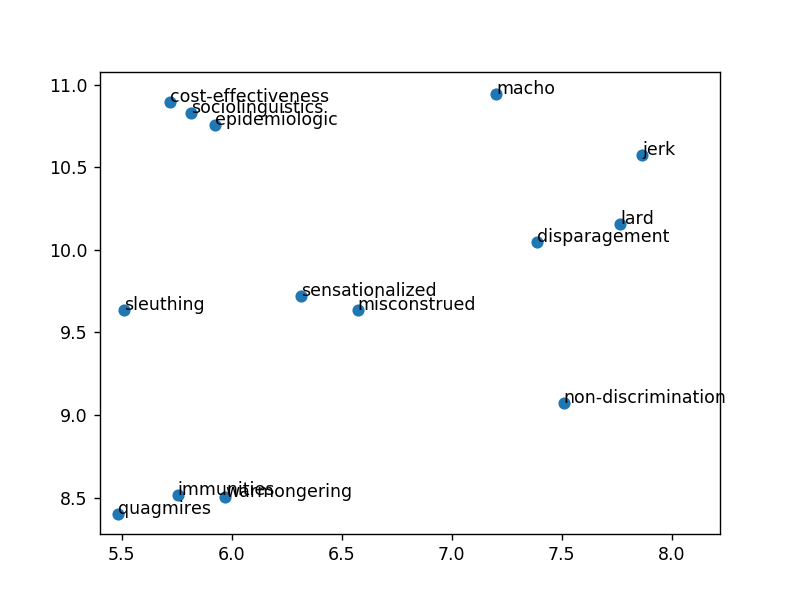

In [1]:
# Part 2 - Experiments

import random
import numpy as np
import scipy
import re
import nltk
import matplotlib.pyplot as plt
import cPickle
import math
import os

from collections import Counter
from pyspark.sql import SparkSession
from nltk.corpus import stopwords as Stopwords
from sklearn.manifold import TSNE
from IPython.display import Image
from IPython.display import display as Display

#####################################################################################

# Part B functions
def getSortedSimilarity(static_vector, vocab_list, vectors_dict, cutoff):
    vocabRDD = spark.sparkContext.parallelize(vocab_list)
    similarity_list = vocabRDD.map(lambda word: \
                                   similarityMap(word, vectors_dict, static_vector)).\
                                   collect()
    similarity_list.sort(key=lambda x: x[1], reverse=True)
    return similarity_list[:cutoff]

def similarityMap(word, vectors_dict, static_vector):
    return (word, calcCosineSimilarity(vectors_dict[word], static_vector))

def calcCosineSimilarity(vector1, vector2):
    v1_mag = np.linalg.norm(vector1)
    v2_mag = np.linalg.norm(vector2)

    denominator = float(v1_mag) * float(v2_mag)

    numerator = float(np.dot(vector1, vector2))

    return numerator/denominator

    # NOTE: Using cosine distance produces better results than normalized Euclidean distance
    # The code for E.D remains below
    # return np.linalg.norm(np.subtract(vector1/np.linalg.norm(vector1),vector2/np.linalg.norm(vector2)))

# Part C functions

# assumes analogy is of the form word1:word2 :: word3 : ?
def getAnalogyVector(word1, word2, word3, vectors_dict):
    try:
        return np.add(np.subtract(vectors_dict[word2], vectors_dict[word1]), vectors_dict[word3])
    except KeyError:
        return None

# Part D functions
def getAnalogyList(directory):
    analogy_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"): 
            filepath = os.path.join(directory, filename)
            with open(filepath, "r") as f:
                for line in f:
                    wordlist = line.lower().strip().\
                               replace('=', ' ').replace(':', ' ').replace('?', ' ').split()
                    if len(wordlist) >= 3:
                        analogy_list.append((wordlist[0], wordlist[1], wordlist[2]))
                        
    return analogy_list

#####################################################################################
EMBEDDINGS_DUMP_PATH = "salty_pickled_embeddings"

PRETRAINED_GLOVE_PATH = './GloVe/glove.6B.50d.txt'

PART_B_VOCAB_LIST = ['physics', 'republican', 'einstein', 'algebra', 'fish']

P2_PLOT_PATH = 'p2_plot.png'

ANALOGIES_FOLDER = '/project/cmsc25025/assn4_analogy/'

NUM_SIMILAR_TO_SHOW = 5 + 1

# Setup

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

# PART A

# load local GloVe embeddings
local_glove_vocab_file = './GloVe/wiki-vocab.txt'
local_glove_vectors_file = './GloVe/wiki-vectors.txt'

local_glove_words = []
local_glove_vectors = {}

with open(local_glove_vocab_file, 'r') as f:
    local_glove_words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(local_glove_vectors_file, 'r') as f:
    for line in f:
        local_glove_vals = line.rstrip().split(' ')
        local_glove_vectors[local_glove_vals[0]] = [float(x) for x in local_glove_vals[1:]]
    
local_glove_vocab  = {w: indx for indx, w in enumerate(local_glove_words)}
local_glove_indx_vocab = {indx: w for indx, w in enumerate(local_glove_words)}

# Then, for example, to obtain the word embedding for the word 'umbrella',
# you could run the following: vectors[’umbrella’]

# load pretrained embeddings

pt_glove_words = []
pt_glove_vectors = {}

with open(PRETRAINED_GLOVE_PATH, 'r') as f:
    
    for line in f:
        pt_glove_vals = line.rstrip().split(' ')
        pt_glove_words.append(pt_glove_vals[0])
        pt_glove_vectors[pt_glove_vals[0]] = [float(x) for x in pt_glove_vals[1:]]
    
pt_glove_vocab  = {w: indx for indx, w in enumerate(pt_glove_words)}
pt_glove_indx_vocab = {indx: w for indx, w in enumerate(pt_glove_words)}

# load pickled PMI embeddings
pmi_words = []
pmi_vectors = {}
with open(EMBEDDINGS_DUMP_PATH, 'r') as f:
    pmi_data = cPickle.load(f)
    for key, data in pmi_data:
        pmi_words.append(key)
        pmi_vectors[key] = data
        
pmi_vocab  = {w: indx for indx, w in enumerate(pmi_words)}
pmi_indx_vocab = {indx: w for indx, w in enumerate(pmi_words)}

# PART B
print "Entering part B"
for word in PART_B_VOCAB_LIST:
    print "Most similar words to " + word + ":"
    print "\n\tFor PMI embeddings:"
    PMI_output = getSortedSimilarity(pmi_vectors[word], pmi_words, pmi_vectors, NUM_SIMILAR_TO_SHOW)
    for line in PMI_output:
        print "\t" + str(line[0]) + " " + str(line[1])

    print "\n\tFor local GloVe embeddings:"
    local_glove_output = getSortedSimilarity(local_glove_vectors[word], local_glove_words,
                                             local_glove_vectors, NUM_SIMILAR_TO_SHOW)
    for line in local_glove_output:
        print "\t" + str(line[0]) + " " + str(line[1])

    print "\n\tFor pretrained GloVe embeddings:"
    pt_glove_output = getSortedSimilarity(pt_glove_vectors[word], pt_glove_words,
                                          pt_glove_vectors, NUM_SIMILAR_TO_SHOW)
    for line in pt_glove_output:
        print "\t" + str(line[0]) + " " + str(line[1])
    print

# PART C
print "Entering part C"
word1 = 'france'
word2 = 'paris'
word3 = 'england'

analogy_vector_pmi = getAnalogyVector(word1, word2, word3, pmi_vectors)
analogy_vector_local_glove = getAnalogyVector(word1, word2, word3, local_glove_vectors)
analogy_vector_pt_glove = getAnalogyVector(word1, word2, word3, pt_glove_vectors)

word_pmi = getSortedSimilarity(analogy_vector_pmi, pmi_words, pmi_vectors, 2)[1] # NOTE: 2 b/c otherwise we get the word again
word_local_glove = getSortedSimilarity(analogy_vector_local_glove, local_glove_words, \
                                       local_glove_vectors, 2)[1]
word_local_pt_glove = getSortedSimilarity(analogy_vector_pt_glove, pt_glove_words, \
                                          pt_glove_vectors, 2)[1]
print "Analogy completion for france:paris :: england:?"
print "PMI: " + str(word_pmi)
print "Local GloVe: " + str(word_local_glove)
print "Pretrained GloVe" + str(word_local_pt_glove)

# PART D
print "Entering part D"
analogy_list = getAnalogyList(ANALOGIES_FOLDER) # a list of tuples (word1, word2, word3)
count = 0
for word1, word2, word3 in analogy_list:
    analogy_vector_pmi = getAnalogyVector(word1, word2, word3, pmi_vectors)
    analogy_vector_local_glove = getAnalogyVector(word1, word2, word3, local_glove_vectors)
    analogy_vector_pt_glove = getAnalogyVector(word1, word2, word3, pt_glove_vectors)
    
    if analogy_vector_pmi is None or analogy_vector_local_glove is None \
                          or analogy_vector_pt_glove is None:
        continue

    word_pmi = getSortedSimilarity(analogy_vector_pmi, pmi_words, pmi_vectors, 1)[0]
    word_local_glove = getSortedSimilarity(analogy_vector_local_glove, local_glove_words, \
                                           local_glove_vectors, 1)[0]
    word_local_pt_glove = getSortedSimilarity(analogy_vector_pt_glove, pt_glove_words, \
                                              pt_glove_vectors, 1)[0]
    print "\nAnalogy completion for " + word1 + ":" + word2 + "::" + word3 + ":?"
    print "PMI: " + str(word_pmi)
    print "Local GloVe: " + str(word_local_glove)
    print "Pretrained GloVe" + str(word_local_pt_glove)
    
    if count >= 100:
        break
    count += 1

# PART E
# import matplotlib.pyplot as plt
# %matplotlib notebook

# tsne = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
# words = []
# vectors = []

# for key in pt_glove_vectors:
#     words.append(key.decode('utf8'))
#     vectors.append(np.array(pt_glove_vectors[key]))

# words = np.array(words)
# vectors = np.array(vectors)

# Y = tsne.fit_transform(vectors[:1000,:])
# plt.scatter(Y[:, 0], Y[:, 1])
# for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
#plt.show()
print "Entering part E"
Display(Image(filename='p2_plot.png')) 

spark.stop()


In [ ]:
# Comments:
# B)
# The n-closests words in the embedding space appears to work quite well for all 3 sets of embeddings.
# It is difficult to say which set of embeddings is the best, as all produce results which are
# valid and make sense. We did find that using cosine similarity produced significantly better results
# than using Euclidian distance, which produced non-sensical results, so we use cosine similarity
# for all further distance analysis
# D)
# The analogy completions are interesting, if not accurate.
# For straightforward associative analogies, such as (city:country) and (subject:person),
# the embeddings seem to work well on average, although some results are non-sensical.
# The local GloVe embeddings and the PMI embeddings seem to work better than the pretrained GloVe embeddings here.
# For synantically similar analogies such as (runner:run), the embeddings seem to struggle across the board,
# due perhaps to the way the vector using the other 3 words in the analogy is calculated. Specifically,
# the algorithm returns the same word often with these analogies, which is not made noticably better by using the second
# most similar word.
# Similarly questionable results can be found with analogies which contain opposites, such as (night:day),
# which return the same word or another seemingly unrelated word
# As a whole, the PMI embeddings seem to outperform the local glove embeddings, which outperform the
# pretrained embeddings

# E)
# This subsection of the plot is interesting. We see in the top left "cost-effectiveness", which a reasonable
# viewer would not expect to be associated with the other two words in close proximity to it.
# A similar observation can be made of the "quagmire", "war-mongering", and "immunities" cluster in the bottom left.
# "Sluething" also seems out of place, which makes it interesting.
# In the top right, we see insulting phrases linked to "disparagment," with "non-disparagement" below it, which is
# a midly humourous juxtapostion.
# In the middle, we see "sensationalized" and "misconstrued", two similar words in context, together.
# As a whole, the fact that these subclusters are close in space is interesting, as it suggests that they appear
# in similar contexts, a rather unexpected result